# Part 1: Loading libs and database

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from sklearn.preprocessing import minmax_scale
from sklearn import metrics

In [2]:
df = pd.read_csv('flux.csv')

# Part 2: Exploratory Data Analysis

In [3]:
#Giving a first look at the data
df

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
...,...,...,...,...,...,...,...,...,...,...
4180475,2020-06-02,12930001,0.375,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180476,2020-06-03,12930001,0.342,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180477,2020-06-04,12930001,0.325,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180478,2020-06-05,12930001,0.311,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617


In [4]:
#Checking types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date        object 
 1   basin_id    int64  
 2   flux        float64
 3   precip      float64
 4   temp_max    float64
 5   gauge_name  object 
 6   lat         float64
 7   lon         float64
 8   mean_elev   float64
 9   area_km2    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 318.9+ MB


In [5]:
#Converting the date column to the right type
df['date'] = pd.to_datetime(df['date'])

In [6]:
#Checking for missing data
df.isna().sum()

date             0
basin_id         0
flux             0
precip        5443
temp_max      5443
gauge_name       0
lat              0
lon              0
mean_elev        0
area_km2         0
dtype: int64

In [7]:
df.nunique()

date            14768
basin_id          503
flux            35978
precip        1384281
temp_max      3901982
gauge_name        503
lat               485
lon               454
mean_elev         500
area_km2          500
dtype: int64

In [8]:
#Analyzing the missig data.
df[df.isna().any(axis=1)].agg(['max','min','nunique'])

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
max,2020-06-06 00:00:00,12930001,7127.74,NaN,NaN,Rio Volcan En Queltehues,-17.8428,-67.6392,4699.293554,27402.563558
min,2020-05-01 00:00:00,1021001,0.00,NaN,NaN,Estero Arrayan En La Montosa,-54.9469,-73.3922,151.476835,20.416816
nunique,37,174,3928.00,0.0,0.0,174,172.0000,169.0000,174.000000,174.000000


In [9]:
df[np.invert(df.isna().any(axis=1))].agg(['max','min'])

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
max,2020-04-30,12930001,15805.0,213.21202,40.811165,Zanjon De La Aguada Puente Particular,-17.8428,-67.6392,4910.151840,52243.667091
min,1980-01-01,1001001,0.0,0.00000,-11.603588,Captacion Lenca,-54.9469,-73.6667,118.122945,17.891227


### The latter observartions don't have values for 'precip' and 'temp_max'. It might represent a delay in gathering those variables, but for simplicity we will just desconsider those observations in the modeling phase

In [10]:
#Checking if there's only one observation by date and station. 
df.duplicated(['gauge_name','date'], keep=False).sum()

0

In [11]:
#Giving a look at ranges, variability and central metrics
df.describe()

,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2
count,4.180480e+06,4.180480e+06,4.175037e+06,4.175037e+06,4.180480e+06,4.180480e+06,4.180480e+06,4.180480e+06
mean,7.179757e+06,5.253340e+01,2.947445e+00,1.365728e+01,-3.569572e+01,-7.129595e+01,1.760129e+03,2.404876e+03
std,3.180965e+06,1.676027e+02,8.766749e+00,6.615037e+00,8.047659e+00,1.254339e+00,1.382121e+03,4.322051e+03
min,1.001001e+06,0.000000e+00,0.000000e+00,-1.160359e+01,-5.494690e+01,-7.366670e+01,1.181229e+02,1.789123e+01
25%,4.558001e+06,8.680000e-01,0.000000e+00,9.162867e+00,-3.915000e+01,-7.231670e+01,5.847012e+02,3.761001e+02
50%,7.350003e+06,5.171000e+00,0.000000e+00,1.321396e+01,-3.588420e+01,-7.137190e+01,1.195311e+03,8.205541e+02
75%,9.416001e+06,2.990000e+01,6.422626e-01,1.805745e+01,-3.126560e+01,-7.050670e+01,3.048161e+03,2.461610e+03
max,1.293000e+07,1.580500e+04,2.132120e+02,4.081117e+01,-1.784280e+01,-6.763920e+01,4.910152e+03,5.224367e+04


In [12]:
#Looking for variability in data and how many rows (dates) are collected in each station
df.groupby('basin_id').nunique().sort_values('date')

,date,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
basin_id,,,,,,,,,
10683002,175,125,115,175,1,1,1,1,1
5423002,195,155,12,195,1,1,1,1,1
4534001,195,173,17,195,1,1,1,1,1
8117001,302,266,95,302,1,1,1,1,1
6034001,328,292,111,328,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
9129002,14603,1529,6328,14566,1,1,1,1,1
4320001,14634,1611,3626,14600,1,1,1,1,1
4703002,14639,1700,2414,14606,1,1,1,1,1


In [13]:
#checking if the date observations are continuous or not
df_dt = df.groupby('basin_id')['date'].agg(['min', 'max', 'count'])
df_dt['dif'] = df_dt['max'] - df_dt['min']
df_dt

,min,max,count,dif
basin_id,,,,
1001001,1980-01-01,2004-05-25,6125,8911 days
1001002,1980-01-01,2019-12-31,12308,14609 days
1001003,1988-06-16,2019-06-30,9322,11336 days
1020002,1980-06-05,2017-11-15,11791,13677 days
1020003,1984-11-30,2018-09-30,11720,12357 days
...,...,...,...,...
12872001,2005-01-12,2016-02-16,3654,4052 days
12876001,1981-05-12,2020-06-06,13522,14270 days
12876004,2007-09-26,2016-08-31,1475,3262 days


#### We saw that the number of observations is smaller than the range between the min and max dates, and the min and max dates vary a lot
#### Let's see the intervals and gaps in the data collection throughout the days, where each row is a station

Text(0.5, 1.0, 'Data distribution across watershed and date')

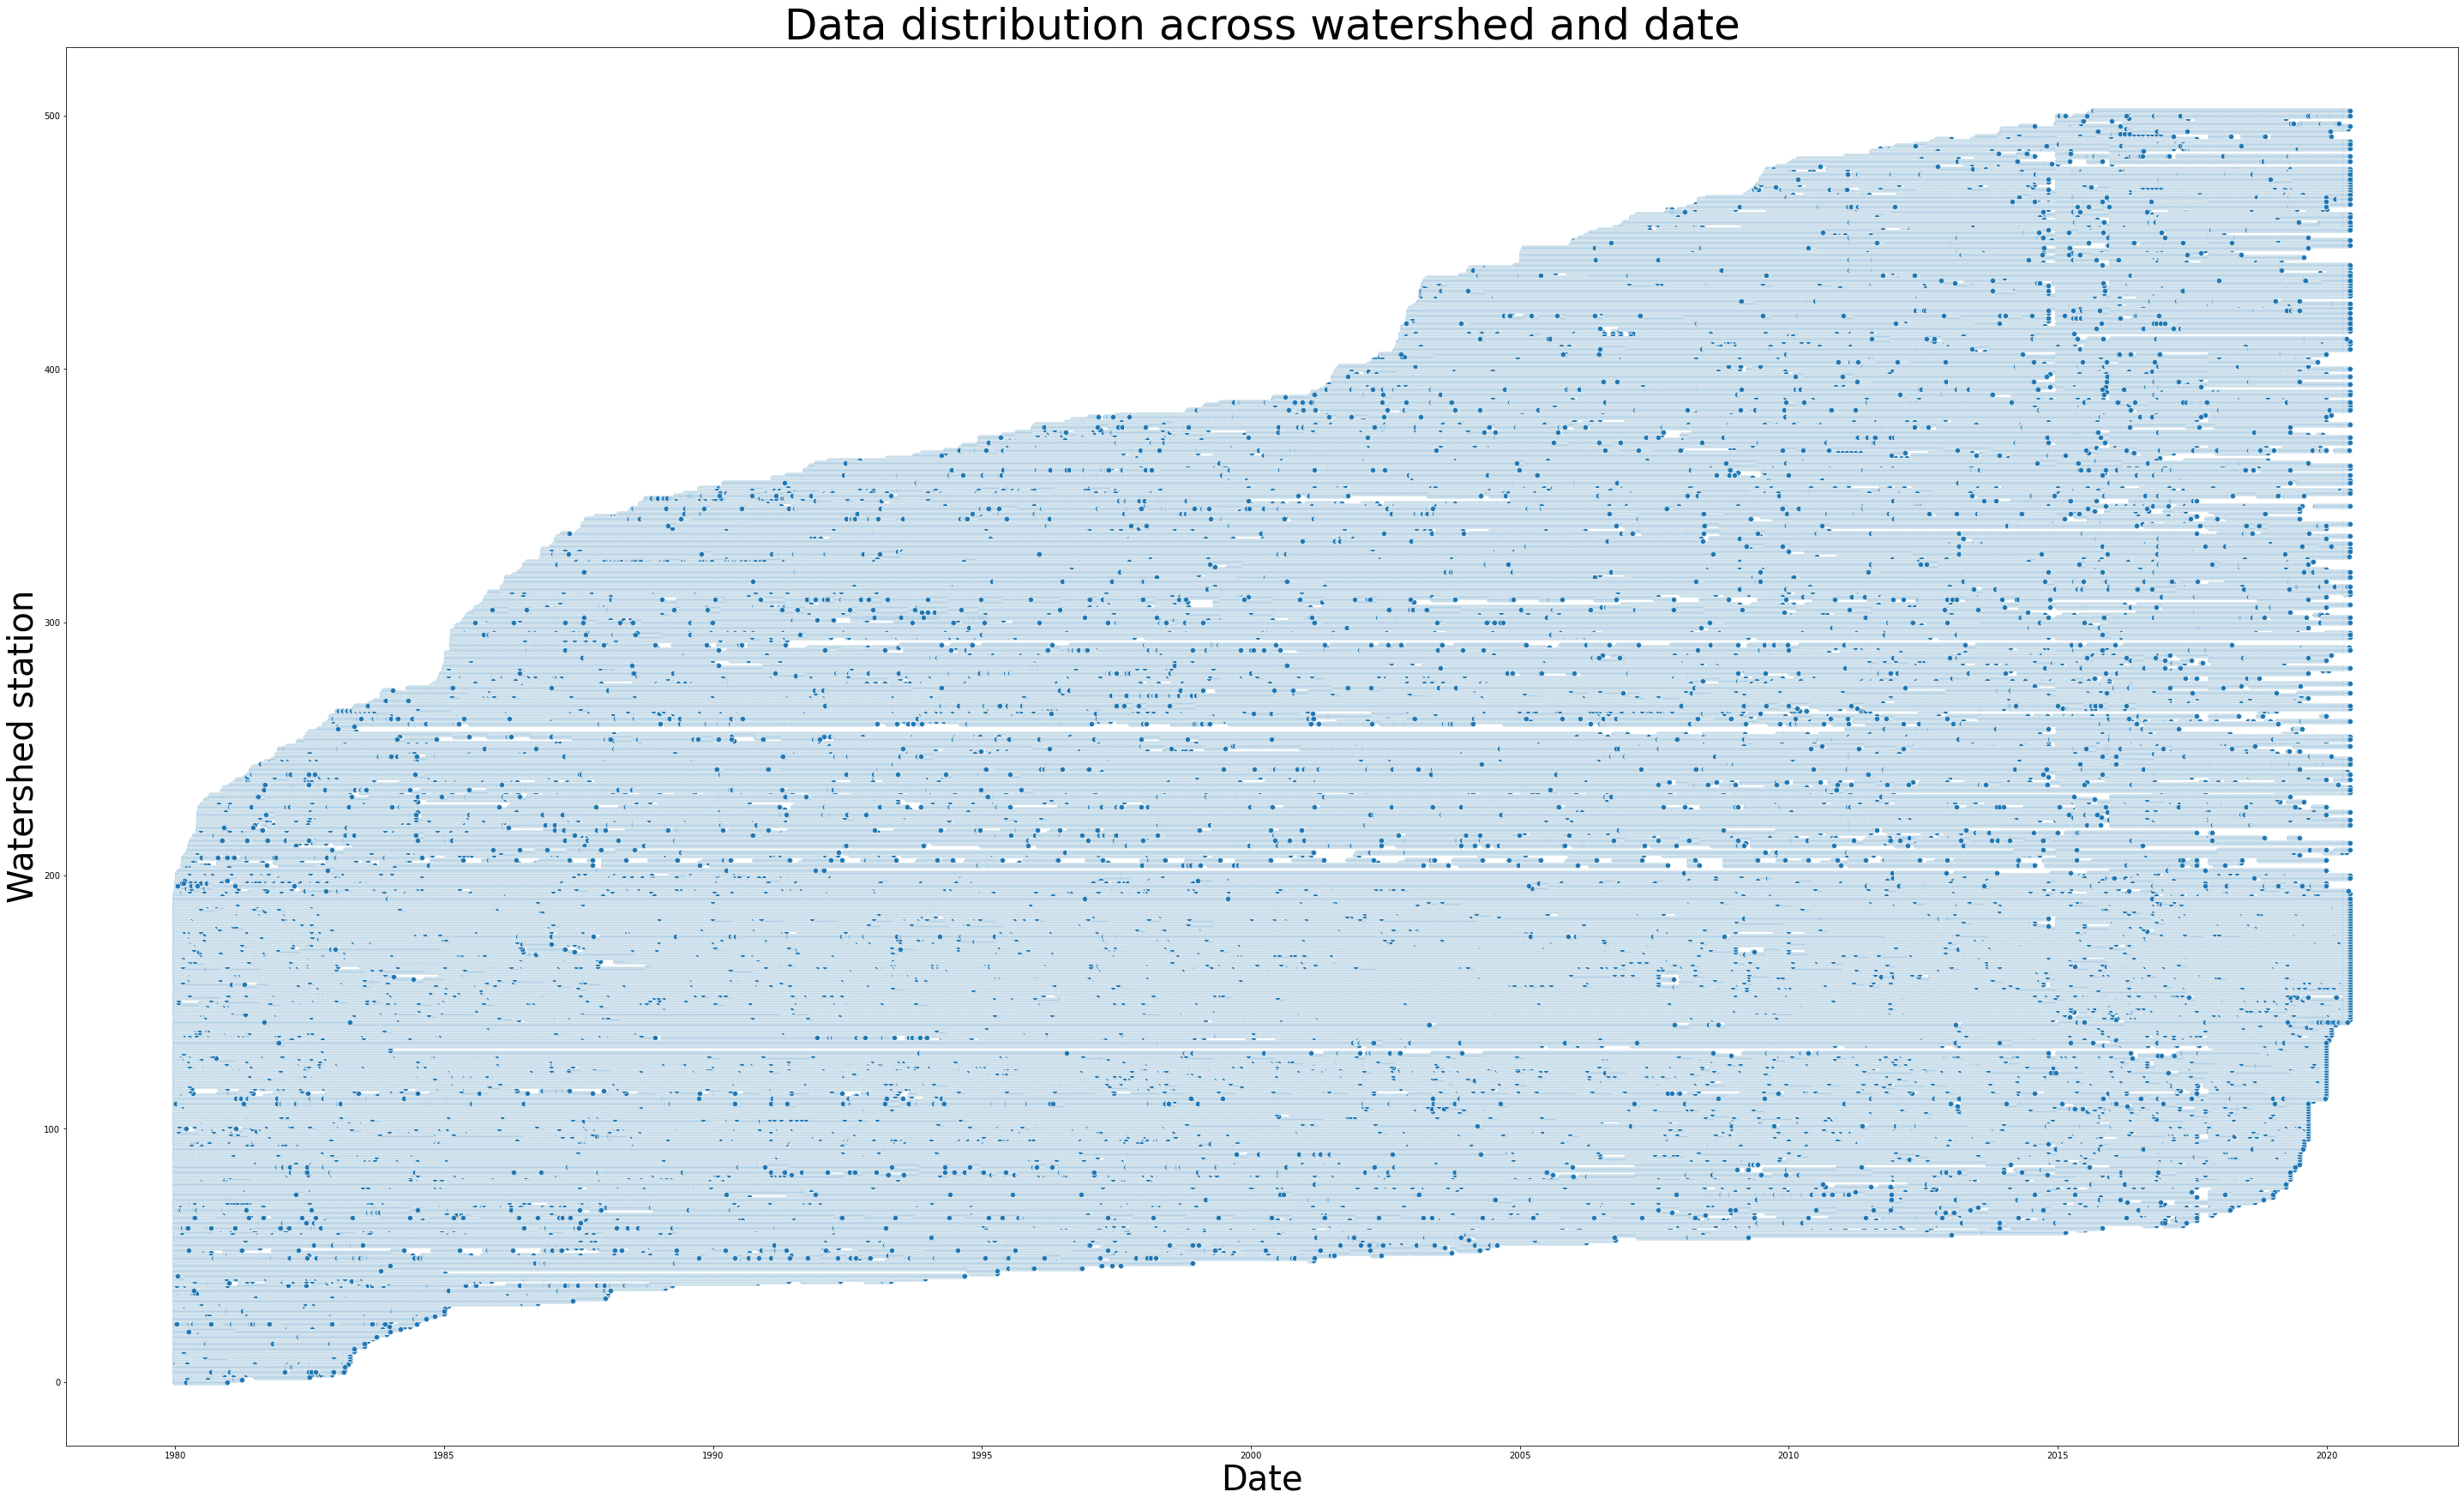

In [14]:
#Data wrangling to generate the graph
df_dt = df_dt.sort_values(['min','max'])
df_dt['row'] = range(len(df_dt))
indices = df_dt.reset_index()[['basin_id', 'row']]
dfnew = df.merge(indices)
ax, fig = plt.subplots(figsize=[50,30])
sns.scatterplot(x = 'date', y = 'row', data = dfnew)
plt.xlabel('Date', fontsize=40);
plt.ylabel('Watershed station', fontsize=40);
plt.title('Data distribution across watershed and date', fontsize=50)

#### There are a lot of ins and outs of watershed stations. We would need to dive deeper into this and see if the variability in data comes mostly from the different watersheds

Text(0.5, 1.0, 'Flux histogram')

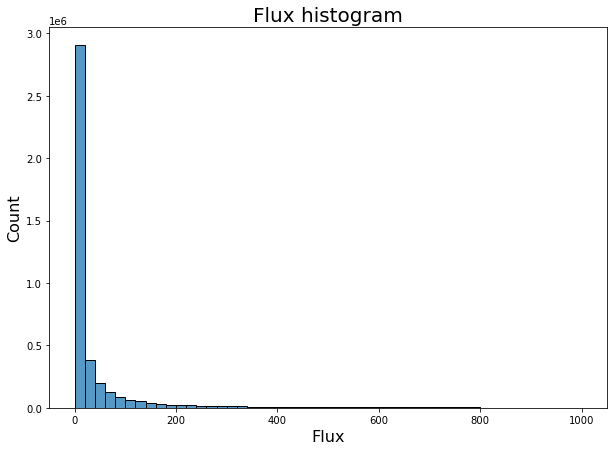

In [15]:
#Giving a look at flux distribution. Seems like even a mean event would be an extreme one
ax, fig = plt.subplots(figsize=[10,7])
sns.histplot(data = df[(df['flux'] < 1000)], x='flux', bins = 50)
plt.xlabel('Flux', fontsize=16);
plt.ylabel('Count', fontsize=16);
plt.title('Flux histogram', fontsize=20)

Text(0.5, 1.0, 'Distribution of watershed station locations and mean elevation')

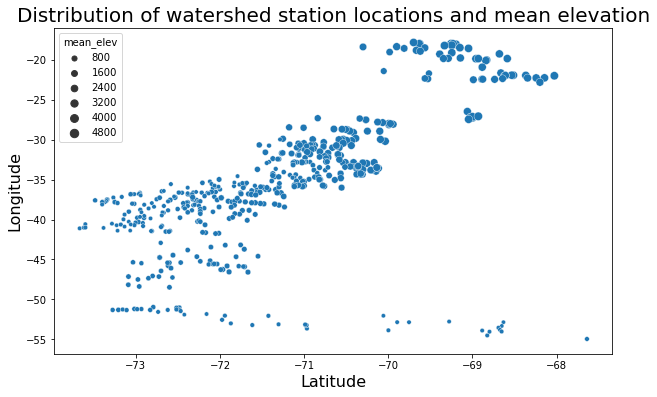

In [16]:
#Giving a look at spatial distribution. In a second version we could use a map to give better insights.
df_geo = df.groupby(['basin_id','lat','lon','mean_elev', 'area_km2']).size().reset_index()

ax, fig = plt.subplots(figsize=[10,6])
sns.scatterplot(data = df_geo, x='lon', y='lat', size = 'mean_elev')
plt.xlabel('Latitude', fontsize=16);
plt.ylabel('Longitude', fontsize=16);
plt.title('Distribution of watershed station locations and mean elevation', fontsize=20)

Text(0.5, 1.0, 'Distribution of watershed station mean elevation')

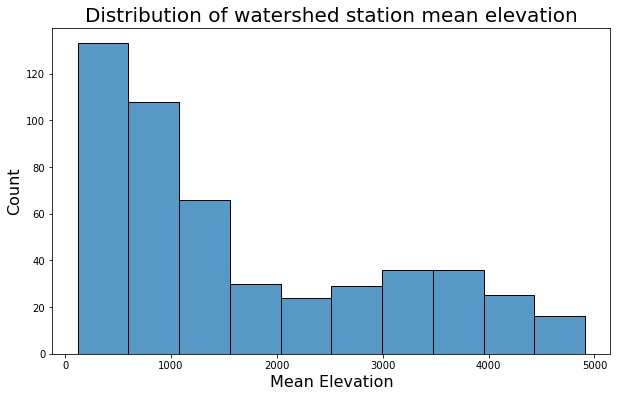

In [17]:
#Checking on mean elevation
ax, fig = plt.subplots(figsize=[10,6])
sns.histplot(data = df_geo, x='mean_elev')
plt.xlabel('Mean Elevation', fontsize=16);
plt.ylabel('Count', fontsize=16);
plt.title('Distribution of watershed station mean elevation', fontsize=20)


Text(0.5, 1.0, 'Distribution of watershed station area')

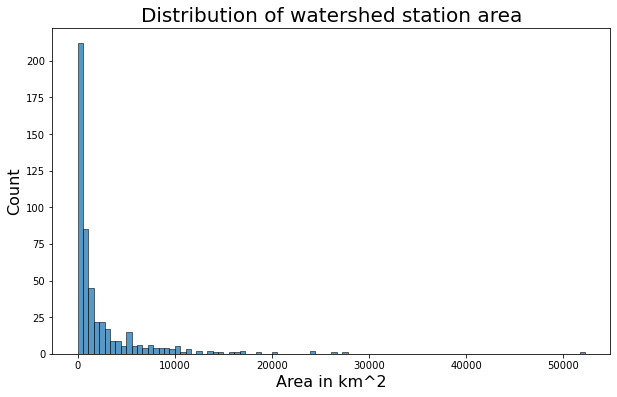

In [18]:
#Checking on area

ax, fig = plt.subplots(figsize=[10,6])
sns.histplot(data = df_geo, x='area_km2')
plt.xlabel('Area in km^2', fontsize=16);
plt.ylabel('Count', fontsize=16);
plt.title('Distribution of watershed station area', fontsize=20)

# Part 3: Plot flux, temperature and precipitations:
Creation of the functions and usage example

In [19]:
#Write a function that plot a time series of a specific variable (flux, temp, precip) from a station.
def plot_one_timeserie(cod_station, variable, min_date, max_date):
    
    #string input to right format    
    min_date = pd.to_datetime(min_date)
    max_date = pd.to_datetime(max_date)
    
    #subset and inspection of ranges    
    df_plot = df[(df['basin_id'] == cod_station)]
    min_df_date = df_plot['date'].min()
    max_df_date = df_plot['date'].max()
    if min_date < min_df_date:
        print('the earliest observed date in this station is', min_df_date)
    else:
        df_plot = df_plot[(df_plot['date'] >= min_date)]

    if max_date > max_df_date:
        print('the latest observed date in this station is', max_df_date)
    else:
        df_plot = df_plot[(df_plot['date'] <= max_date)]

    #graph plot
    ax, fig = plt.subplots(figsize=[20,7])
    sns.lineplot(x='date', y=variable, data=df_plot)
    plt.xlabel('Date', fontsize=16);
    plt.ylabel(variable,fontsize=16);
    plt.title(('Distribution of {} in watershed station of code {}').format(variable,cod_station), fontsize=20)


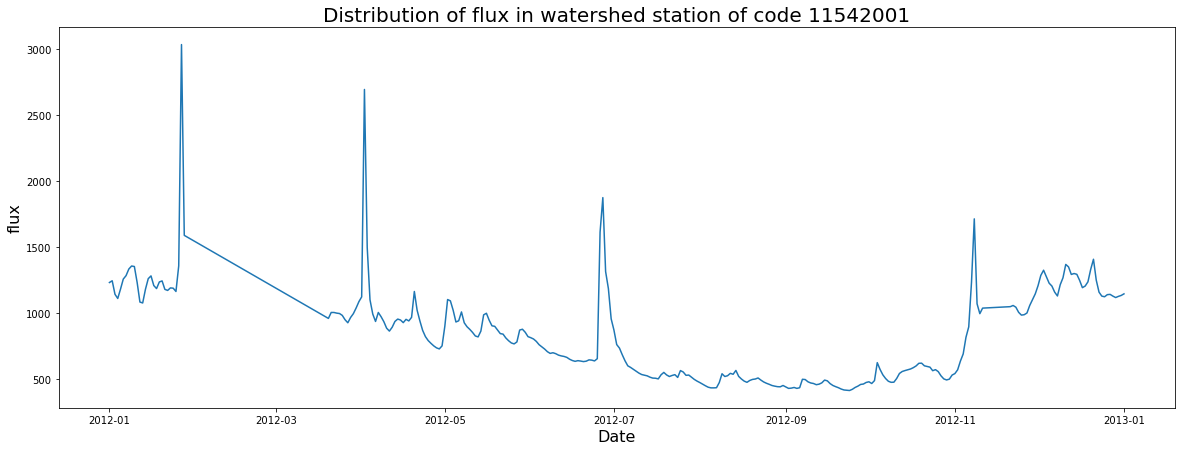

In [20]:
plot_one_timeserie(11542001,'flux','2012-01-01','2013-01-01')

In [21]:
def plot_three_timeseries(cod_station, min_date, max_date):
    #string input to right format
    min_date = pd.to_datetime(min_date) 
    max_date = pd.to_datetime(max_date)
    
    #subset and inspection of ranges
    df_plot = df[(df['basin_id'] == cod_station)] 
    min_df_date = df_plot['date'].min()
    max_df_date = df_plot['date'].max()
    
    if min_date < min_df_date:
        print('the earliest observed date in this station is', min_df_date)
    else:
        df_plot = df_plot[(df_plot['date'] >= min_date)]

    if max_date > max_df_date:
        print('the latest observed date in this station is', max_df_date)
    else:
        df_plot = df_plot[(df_plot['date'] <= max_date)]
    
    cols = ['flux', 'temp_max', 'precip']
    
    #Scale and graph plot
    df_plot_copy = df_plot.copy() 
    df_plot_copy.loc[:,cols] = minmax_scale(df_plot.loc[:,cols])
    df_plot_copy[cols]
    df_plot2 = pd.melt(df_plot_copy, id_vars=['date'], value_vars=['flux', 'temp_max', 'precip'])
    ax, fig = plt.subplots(figsize=[20,7])
    sns.lineplot(x='date',y='value', hue='variable',data=df_plot2)
    plt.xlabel('Date', fontsize=16);
    plt.ylabel('Value normalized',fontsize=16);
    plt.title(('Distribution of flux, temp_max and precip in watershed station of code {}').format(cod_station), fontsize=20)

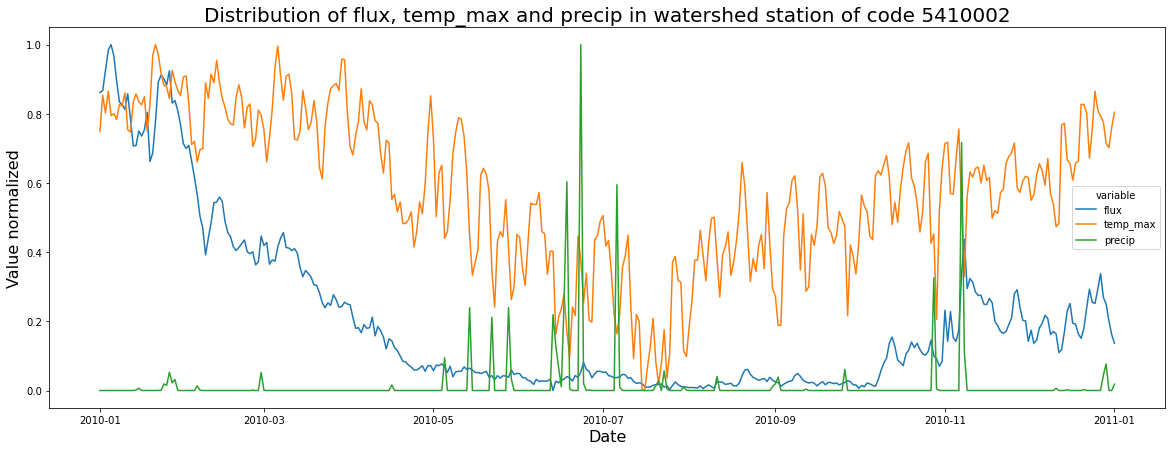

In [22]:
plot_three_timeseries(5410002,'2010-01-01','2011-01-01')

# Part 4: creation of the variables flux_extreme, temp_extreme, precip_extreme.
The author proposed that those variables can be considered as extreme (value 1) when they are over the 95 percentile of the variable distribution for that specific season, and take the value 0 otherwise.
In general I think that it is not a good method because even with a really small range,
there would always be a 95 percentile, but it wouldn't be an extreme value.

One way to find extreme values is the z-score, that measures how far the value is from the mean. And we will do that by season as we saw that it has different levels in the EDA.

A more robust way would be to have a rolling mean and std calculation

In [23]:
month_map = {11: 'summer',
              12: 'summer',
              1: 'summer', 
              2: 'fall', 
              3: 'fall', 
              4: 'fall',
              5: 'winter',
              6: 'winter', 
              7: 'winter', 
              8: 'spring', 
              9: 'spring',
              10: 'spring'}
df['month'] = pd.DatetimeIndex(df['date']).month
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['year'] = pd.DatetimeIndex(df['date']).year
df['season'] = df['month'].map(month_map)


def estimate_z_score(series):
    return (series - series.mean())/series.std()

#calcuating the score
df['flux_z_score'] = df.groupby('season')['flux'].apply(estimate_z_score)
df['temp_z_score'] = df.groupby('season')['temp_max'].apply(estimate_z_score)
df['precip_z_score'] = df.groupby('season')['precip'].apply(estimate_z_score)

#Creating flux_extreme, temp_extreme, precip_extreme with the threshold of 2 std
df['flux_extreme'] = [1 if flux_z_score >= 2 else 0 for flux_z_score in df['flux_z_score']]
df['temp_extreme'] = [1 if temp_z_score >= 2 else 0 for temp_z_score in df['temp_z_score']]
df['precip_extreme'] = [1 if precip_z_score >= 2 else 0 for precip_z_score in df['precip_z_score']]
extremes = ['flux_extreme','temp_extreme','precip_extreme']

In [24]:
#Frequency of extreme events in the dataset
df[['flux_extreme','temp_extreme', 'precip_extreme']].agg('sum')/len(df)

flux_extreme      0.033035
temp_extreme      0.020921
precip_extreme    0.042264
dtype: float64

# Part 5: Plot the variable flux_extreme

In [25]:
df_watersheds = df.groupby('gauge_name')[extremes].agg(['sum', 'size'])
df_watersheds['prop_flux'] = df_watersheds['flux_extreme']['sum']/df_watersheds['flux_extreme']['size']
df_watersheds['prop_temp'] = df_watersheds['temp_extreme']['sum']/df_watersheds['temp_extreme']['size']
df_watersheds['prop_precip'] = df_watersheds['precip_extreme']['sum']/df_watersheds['precip_extreme']['size']

df_watersheds = df_watersheds.reset_index()
df_watersheds = df_watersheds.sort_values('prop_flux', ascending = False)
df_watersheds['percent_of_stations'] = range(len(df_watersheds))
df_watersheds['percent_of_stations'] = (df_watersheds['percent_of_stations']+1)/len(df_watersheds)

Text(0.5, 1.0, 'Frequency of occurence of extreme flux events by watershed stations')

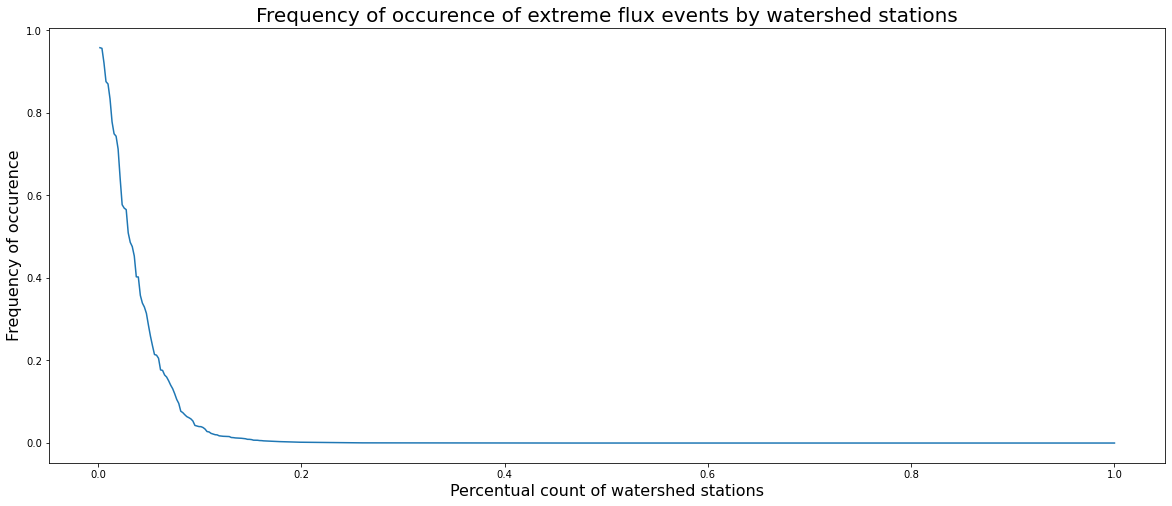

In [26]:
ax, fig = plt.subplots(figsize=[20,8])
sns.lineplot(data = df_watersheds, y='prop_flux',x='percent_of_stations')
plt.xlabel('Percentual count of watershed stations', fontsize=16);
plt.ylabel('Frequency of occurence',fontsize=16);
plt.title('Frequency of occurence of extreme flux events by watershed stations', fontsize=20)

### Are there any different behaviours among different watersheds?
Yes, as we can see about 10% percent of the watersheds concentrate the entire extreme flux events. We would need to dive deeper about the relation between area and

# Part 6: Plot the percentage of extreme events during time. 

In [27]:
df_year = df.groupby('year')[extremes].agg(['sum', 'size'])
df_year['prop_flux'] = df_year['flux_extreme']['sum']/df_year['flux_extreme']['size']
df_year['prop_temp'] = df_year['temp_extreme']['sum']/df_year['temp_extreme']['size']
df_year['prop_precip'] = df_year['precip_extreme']['sum']/df_year['precip_extreme']['size']

df_year = df_year.reset_index()
df_year = df_year.sort_values('prop_flux', ascending = False)

Text(0.5, 1.0, 'Frequency of occurence of extreme events by year')

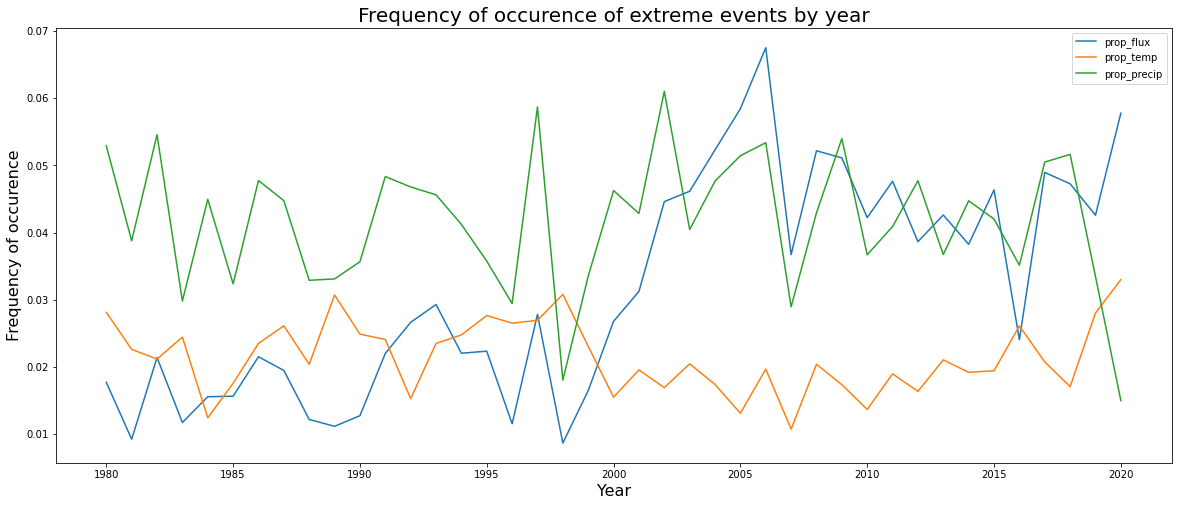

In [28]:
ax, fig = plt.subplots(figsize=[20,8])
sns.lineplot(data = df_year, y='prop_flux', x='year', label= 'prop_flux')
sns.lineplot(data = df_year, y='prop_temp', x='year', label= 'prop_temp')
sns.lineplot(data = df_year, y='prop_precip', x='year', label= 'prop_precip')
plt.xlabel('Year', fontsize=16);
plt.ylabel('Frequency of occurence',fontsize=16);
plt.title('Frequency of occurence of extreme events by year', fontsize=20)

### Have the events become more frequent? 
The extreme flux events became more frequent. The extreme precipitation events doesn't have a clear trend and the extreme temperature eventes seems that it has a upper trend

# Part 7: Extreme flux prediction. 

There will be trained a lightgbm model, for its speed and low memory usage and great accuracy since its an ensemble of trees and it works very well with classification with tabular data

It will be taken as hypothesis that we couldn't use the current and the last day data and we would need five days to act in case of an extreme event, therefore we would need to predict it 7 days ahead.

There will be created lag variables of the quantitative ones to be used as features.


In [29]:
df['flux_extreme_pred'] = df.groupby('basin_id')['flux_extreme'].shift(-7)

In [30]:
#Building new features with the lagged measure of the flux, precip and temp_max variables
columns = ['flux','temp_max','precip']
days = 7
for col in columns:
    for i in range(1,days+1):
        df['{}_l{}'.format(col,i)] = df.groupby('basin_id')[col].shift(i)

In [31]:
df = df.dropna(axis=0)

In [32]:
#Selecting variables
features = df[['lat', 'lon', 'mean_elev', 'area_km2', 'year', 
               'day_of_year', 'temp_max', 'precip','flux',
               'flux_l1','temp_max_l1','precip_l1',
               'flux_l2','temp_max_l2','precip_l2',
               'flux_l3','temp_max_l3','precip_l3', 
               'flux_l4','temp_max_l4','precip_l4',
               'flux_l5','temp_max_l5','precip_l5',
               'flux_l6','temp_max_l6','precip_l6',
               'flux_l7','temp_max_l7','precip_l7']]

y = df['flux_extreme_pred']

#Creating the split. We have a lot of potential here using better houldout methods, such as cross validation for timeseries
train_index = df['date'] < '2011-01-01'
val_index = (df['date'] >= '2011-01-01')

Xtrain, Xval = features[train_index], features[val_index]
ytrain, yval = y[train_index], y[val_index]
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((3084512, 30), (1084696, 30), (3084512,), (1084696,))

In [33]:
#training model
# There's a lot of potential here as well with hyperparameters tuning. 
#Setting clas_weight = balanced to emphasize the recall metric as the percentage of positive values is really small
mdl = LGBMClassifier(random_state=0, class_weight="balanced", n_jobs=6) 
mdl.fit(Xtrain, ytrain)

LGBMClassifier(class_weight='balanced', n_jobs=6, random_state=0)

In [34]:
#Predict
p = mdl.predict(Xval)

In [35]:
# Looking for the most important metrics
tn, fp, fn, tp = metrics.confusion_matrix(yval, p).ravel()
print("tn = ",tn,"fp =", fp, "fn = ", fn,"tp =", tp)
print("recall =", round(metrics.recall_score(yval, p),3))
print("auc_score =", round(metrics.roc_auc_score(yval, p),3))
print("precision_score =", round(metrics.precision_score(yval, p),3))
print("f1_score =", round(metrics.f1_score(yval, p),3))
print("accuracy =", round(metrics.accuracy_score(yval, p),3))

tn =  994907 fp = 44147 fn =  1025 tp = 44617
recall = 0.978
auc_score = 0.968
precision_score = 0.503
f1_score = 0.664
accuracy = 0.958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


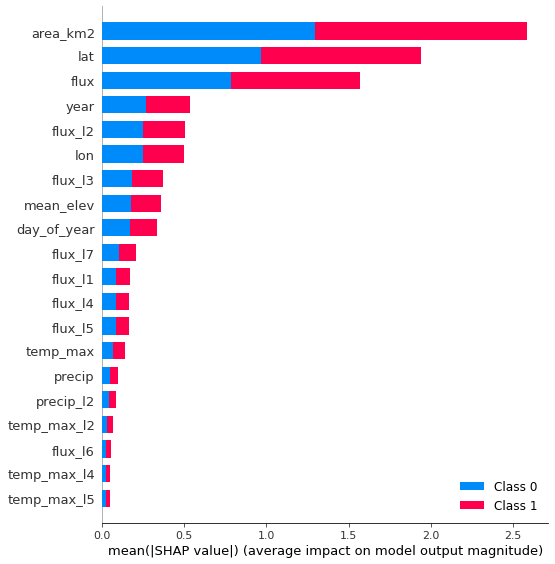

In [36]:
#Investigating the most important features
shap_values = shap.TreeExplainer(mdl).shap_values(Xval)
shap.summary_plot(shap_values, Xval)

##### As we could see in the beggining of the part 6, just a small amount of watersheds concentrate the vast majority of the extreme events. Thus, the algorithm is probabily memorizing these relations. So, I will remove the unique watersheds station data and just work with the lags

In [37]:
features = df[['flux', 'temp_max','precip',
               'flux_l1','temp_max_l1','precip_l1',
               'flux_l2','temp_max_l2','precip_l2',
               'flux_l3','temp_max_l3','precip_l3', 
               'flux_l4','temp_max_l4','precip_l4',
               'flux_l5','temp_max_l5','precip_l5',
               'flux_l6','temp_max_l6','precip_l6',
               'flux_l7','temp_max_l7','precip_l7']]
y = df['flux_extreme_pred']

train_index = df['date'] < '2011-01-01'
val_index = (df['date'] >= '2011-01-01')

Xtrain, Xval = features[train_index], features[val_index]
ytrain, yval = y[train_index], y[val_index]


mdl = LGBMClassifier(random_state=0, class_weight="balanced", n_jobs=6)
mdl.fit(Xtrain, ytrain)
p = mdl.predict(Xval)
tn, fp, fn, tp = metrics.confusion_matrix(yval, p).ravel()
print("tn = ",tn,"fp =", fp, "fn = ", fn,"tp =", tp)
print("recall =", round(metrics.recall_score(yval, p),3))
print("auc_score =", round(metrics.roc_auc_score(yval, p),3))
print("precision_score =", round(metrics.precision_score(yval, p),3))
print("accuracy =", round(metrics.accuracy_score(yval, p),3))
print("f1_score =", round(metrics.f1_score(yval, p),3))

tn =  984833 fp = 54221 fn =  1045 tp = 44597
recall = 0.977
auc_score = 0.962
precision_score = 0.451
accuracy = 0.949
f1_score = 0.617


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


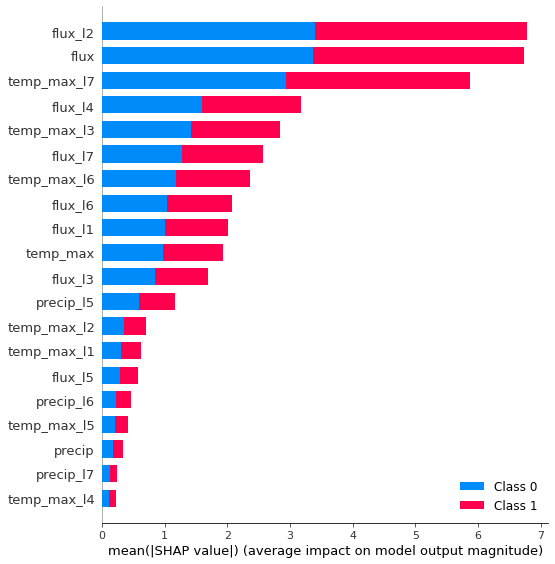

In [38]:
shap_values = shap.TreeExplainer(mdl).shap_values(Xval)
shap.summary_plot(shap_values, Xval)

The performance stayed about the same. 

## Inspection of the relationship between flux and extreme flux events 7 days later

Text(0.5, 1.0, 'Relation between flux and extreme flux event 7 days later')

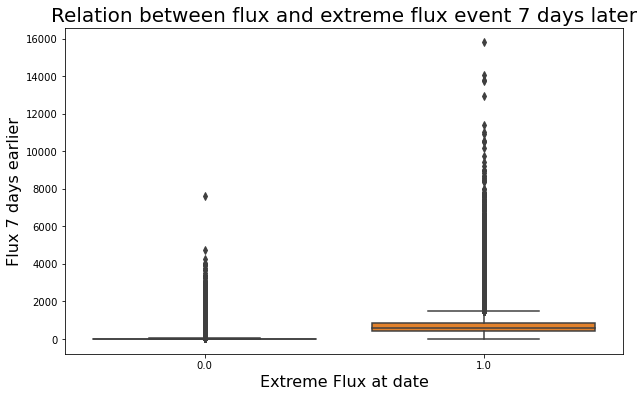

In [39]:
ax, fig = plt.subplots(figsize=[10,6])
sns.boxplot(data=df, y='flux', x = 'flux_extreme_pred')
plt.xlabel('Extreme Flux at date', fontsize=16);
plt.ylabel('Flux 7 days earlier',fontsize=16);
plt.title('Relation between flux and extreme flux event 7 days later', fontsize=20)

Since there's a great dependency between watershed station and frequency of extreme flux (Part 5), there might overfitting this feature. Let's try to remove it.

In [40]:
features = df[['temp_max','precip',
               'temp_max_l1','precip_l1',
               'temp_max_l2','precip_l2',
               'temp_max_l3','precip_l3', 
               'temp_max_l4','precip_l4',
               'temp_max_l5','precip_l5',
               'temp_max_l6','precip_l6',
               'temp_max_l7','precip_l7']]
y = df['flux_extreme_pred']

train_index = df['date'] < '2011-01-01'
val_index = (df['date'] >= '2011-01-01')

Xtrain, Xval = features[train_index], features[val_index]
ytrain, yval = y[train_index], y[val_index]


mdl = LGBMClassifier(random_state=0, class_weight="balanced", n_jobs=6)
mdl.fit(Xtrain, ytrain)
p = mdl.predict(Xval)
tn, fp, fn, tp = metrics.confusion_matrix(yval, p).ravel()
print("tn = ",tn,"fp =", fp, "fn = ", fn,"tp =", tp)
print("recall =", round(metrics.recall_score(yval, p),3))
print("auc_score =", round(metrics.roc_auc_score(yval, p),3))
print("precision_score =", round(metrics.precision_score(yval, p),3))
print("accuracy =", round(metrics.accuracy_score(yval, p),3))
print("f1_score =", round(metrics.f1_score(yval, p),3))

tn =  727565 fp = 311489 fn =  7513 tp = 38129
recall = 0.835
auc_score = 0.768
precision_score = 0.109
accuracy = 0.706
f1_score = 0.193


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


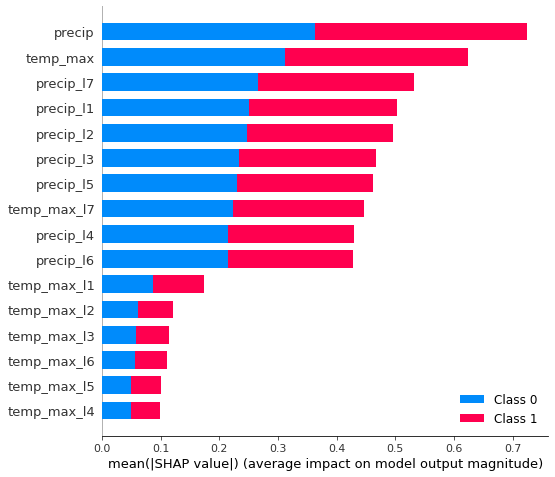

In [41]:
shap_values = shap.TreeExplainer(mdl).shap_values(Xval)
shap.summary_plot(shap_values, Xval)

# Part 8: Analyze the model results.

### a) What is the performance of the model?
It has a good fit with auc score of 0.768. Its recall was high (0.835), which enables a great response to the extreme events. The downside was that most of the extreme flux call would be wrong (0.109), but considering the cost to a type 1 error much higher than type 2, it is a good result. The f-1 scores was low, but it could get better with better training methods (hyperparameter tuning, cross validation)

### Which metrics you consider are the best suited for this problem?
auc score, to see how good is the model fit
recall, because our main objective is not to be caught by surprise when an extreme event occur
precision_score, to see the collateral damage we are making with false positives
mostly f1 score but also accuracy for overall performance 

### What are the most important variables? 
The watershed's station features and the water flux from earlier days were very important.

### What do you think about the results?
It has high recall with a reasonable precision and forecasts 7 days ahead, giving 5 days to prepare, considering that data is lagged in 2 days.

Seems like it is in good fit for production, but this analysis raised a need to deep dive in the relationship between the watersheds stations and extreme events, and in the relationship between sequences of extreme events, evaluating the performance in the first extreme event value in a sequence of extreme events. 

And how we define an extreme event could also be reassessed.


### b) If we wanted to identify at least 70% of the extreme flux events, which are the metrics of your model for that threshold? 
Recall would need to be higher than 70%, since it calculates the proportion of true positive rate detection of all positive results in the dataset. Considering positive an extreme event.

### It is a useful model?
Yes. It has high recall with a reasonable precision and allow us to prepare 5 days ahead.